In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error

Загрузим данные и сразу будем работать со вторыми разностями

In [4]:
df = pd.read_csv('data/POP.csv', index_col=2, parse_dates=True)
df = df[['value']]
df['second_diff'] = df.diff().diff()
df.head()

,value,second_diff
date,,
1952-01-01,156309.0,NaN
1952-02-01,156527.0,NaN
1952-03-01,156731.0,-14.0
1952-04-01,156943.0,8.0
1952-05-01,157140.0,-15.0


<AxesSubplot:xlabel='date'>

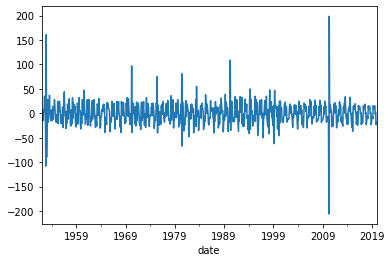

In [5]:
df['second_diff'].plot()

Сделаем преобразование Фурье, построим график в координатах частота-амплитуда. Частоту возьмем $\frac{1}{12}$, так как в году 12 месяцев

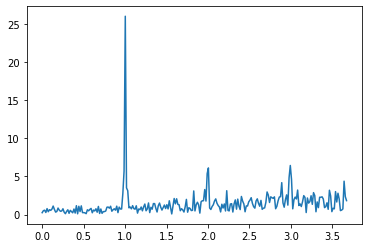

In [13]:
from scipy.fft import fft, ifft, fftfreq

x = df['second_diff'].dropna()
yf = fft(x.values)
xf = fftfreq(len(x), 1/12)[:n//2]
plt.plot(xf, 2 / n * np.abs(yf[:n//2]))

Видим четкий пик в единице. Это означает, что есть сезонность в год. Также если небольшие пики в 2 и 3. Давайте возьмем несколько гармоник, которые вносят наибольший вклад, и построим прогноз.

[Код модели отсюда](https://gist.github.com/tartakynov/83f3cd8f44208a1856ce)

In [26]:
train, test = train_test_split(df['second_diff'].dropna(), train_size=0.8, shuffle=False)
train.shape, test.shape

((651,), (163,))

In [18]:
from numpy import fft

def fourierExtrapolation(x, n_predict, n_harm=10):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)
    x_notrend = x - p[0] * t
    x_freqdom = fft.fft(x_notrend)
    f = fft.fftfreq(n)
    indexes = list(range(n))
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

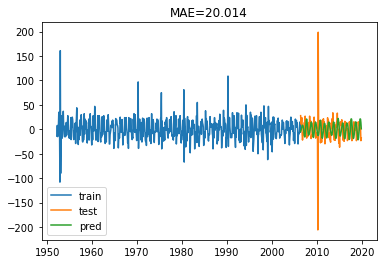

In [126]:
pred = fourierExtrapolation(train, len(test), 100)[len(train):]

plt.plot(train)
plt.plot(test)
plt.plot(test.index, pred)
plt.title(f'MAE={mean_absolute_error(test, pred):.3f}')

plt.legend(['train', 'test', 'pred'])

Попробуем подобрать оптимальное количество гармоник

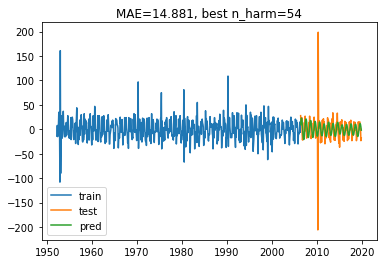

In [113]:
metrics = {}
for n_harm in range(1, 1000):
    pred = fourierExtrapolation(train, len(test), n_harm)[len(train):]
    metrics[n_harm] = mean_absolute_error(test, pred)

n_harm_df = pd.DataFrame(metrics, index=['n_harm']).T
best_n_harm = n_harm_df.n_harm.argmin() + 1

pred = fourierExtrapolation(train, len(test), best_n_harm)[len(train):]

plt.plot(train)
plt.plot(test)
plt.plot(test.index, pred)
plt.title(f'MAE={mean_absolute_error(test, pred):.3f}, best n_harm={best_n_harm}')

plt.legend(['train', 'test', 'pred'])

Теперь вспоминаем, что это ряд из вторых разностей. Чтобы построить прогноз по исходному ряду, нужно сделать обратное преобразование.

Его можно сделать при помощи `np.cumsum()`. Оставляем это вам в качестве упражнения.